In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import telcoacquire

# Remove limits on viewing dataframes
pd.set_option('display.max_columns', None)

---

# Acquire Data

- First we will use the telcoacquire module to import our raw telco data from the codeup database using the following SQL search 

    >`sql_query = '''
                    SELECT * FROM customers
                    JOIN contract_types USING (contract_type_id)
                    JOIN internet_service_types USING (internet_service_type_id)
                    JOIN payment_types USING (payment_type_id)
                    '''`

In [2]:
telco_df = telcoacquire.new_telco_data()

In [3]:
#Leave our imported dataframe pristine while doing initial tests and cleaning and prep on a copy.

raw_data = telco_df

In [4]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [5]:
telco_df.shape

(7043, 24)

## Mini data exploration as prepping and cleaning

- Not looking into any specific variable correlations until the data is split, but need to do some limited visualizations and exploration to see what it is I am looking at and how to best prepare the data.

It appears as if there are redundant columns (id and others with same names). How are they related  

In [6]:
pd.crosstab(raw_data.internet_service_type_id, raw_data.internet_service_type)


internet_service_type,DSL,Fiber optic,None
internet_service_type_id,,,
1,2421,0,0
2,0,3096,0
3,0,0,1526


In [7]:
pd.crosstab(raw_data.contract_type_id, raw_data.contract_type)


contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1473,0
3,0,0,1695


In [8]:
pd.crosstab(raw_data.payment_type_id, raw_data.payment_type)


payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
payment_type_id,,,,
1,0,0,2365,0
2,0,0,0,1612
3,1544,0,0,0
4,0,1522,0,0


## Remove redundant and unnecessary columns 

Since `payment_type_id` duplicates `payment_type`,
`internet_service_type_id` duplicates `internet_service_type`, 
and `contract_type_id` duplicates `contract_type`, we only need one column of each pair. 

Drop the `_id` columns

In [9]:
df = raw_data.copy()

In [10]:
# Drop redundant and unhelpful columns.

df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'], inplace=True)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   phone_service          7043 non-null   object 
 7   multiple_lines         7043 non-null   object 
 8   online_security        7043 non-null   object 
 9   online_backup          7043 non-null   object 
 10  device_protection      7043 non-null   object 
 11  tech_support           7043 non-null   object 
 12  streaming_tv           7043 non-null   object 
 13  streaming_movies       7043 non-null   object 
 14  paperless_billing      7043 non-null   object 
 15  mont

**NOTE:** Total charges appears as an object. Should be a float. Will convert.

In [12]:
df['total_charges'].value_counts()


20.2       11
           11
19.75       9
19.9        8
19.65       8
           ..
908.15      1
3532.85     1
5941.05     1
5168.1      1
3255.35     1
Name: total_charges, Length: 6531, dtype: int64

There are eleven instances where there are blanks for total charges. What is that about?

In [13]:
blanks = df[df.total_charges == ' ']
blanks


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
85,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,Yes,Yes,Yes,No,No,56.05,,No,Two year,DSL,Credit card (automatic)
156,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
236,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,,No,Two year,DSL,Mailed check
255,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,Yes,No,Yes,Yes,Yes,No,Yes,52.55,,No,Two year,DSL,Bank transfer (automatic)
339,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,,No,Two year,DSL,Mailed check
5681,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,,No,Two year,None,Mailed check
5717,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.25,,No,Two year,None,Mailed check
5727,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.35,,No,Two year,None,Mailed check
5798,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.75,,No,Two year,None,Mailed check
6007,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,19.85,,No,Two year,None,Mailed check


In [14]:
new = df[df.tenure == 0]
new

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
85,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,Yes,Yes,Yes,No,No,56.05,,No,Two year,DSL,Credit card (automatic)
156,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
236,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,,No,Two year,DSL,Mailed check
255,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,Yes,No,Yes,Yes,Yes,No,Yes,52.55,,No,Two year,DSL,Bank transfer (automatic)
339,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,,No,Two year,DSL,Mailed check
5681,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,,No,Two year,None,Mailed check
5717,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.25,,No,Two year,None,Mailed check
5727,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.35,,No,Two year,None,Mailed check
5798,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.75,,No,Two year,None,Mailed check
6007,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,19.85,,No,Two year,None,Mailed check


The new customers have blanks for total charges. We could fill these blanks with zeros since they have had no total chatrge, but since these customers are new they really haven't had an opportunity to churn. As such, they won't be informative to our model and can simply be deleted from the entire dataset.

In [15]:
df['total_charges'] = df['total_charges'].str.strip()


In [16]:
df = df[df.total_charges != '']


In [17]:
# Confirm that these rows were dropped
df[df.tenure == 0]


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type


In [18]:
# Convert datatype
df['total_charges'] = df.total_charges.astype(float)

In [19]:
# Confirm datatype changed
df.dtypes

customer_id               object
gender                    object
senior_citizen             int64
partner                   object
dependents                object
tenure                     int64
phone_service             object
multiple_lines            object
online_security           object
online_backup             object
device_protection         object
tech_support              object
streaming_tv              object
streaming_movies          object
paperless_billing         object
monthly_charges          float64
total_charges            float64
churn                     object
contract_type             object
internet_service_type     object
payment_type              object
dtype: object

In [20]:
# View numeric summary statistics
df.describe()

,senior_citizen,tenure,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


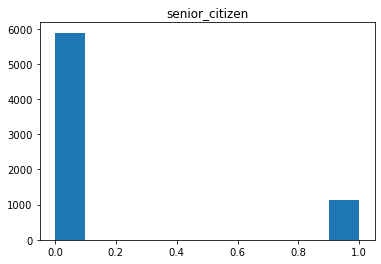

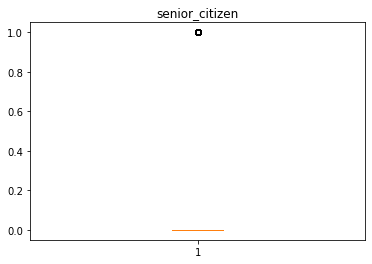

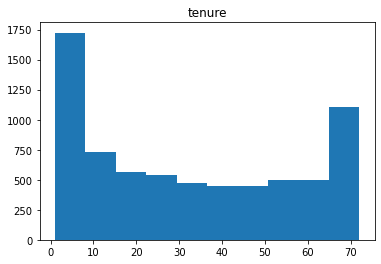

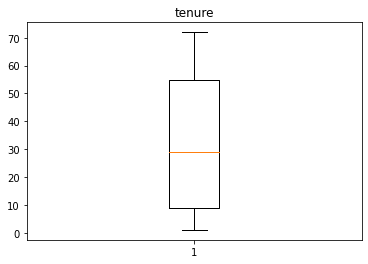

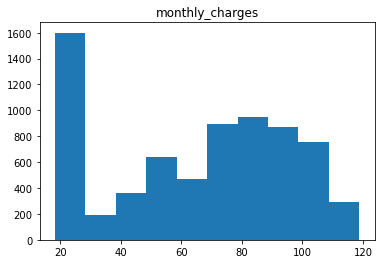

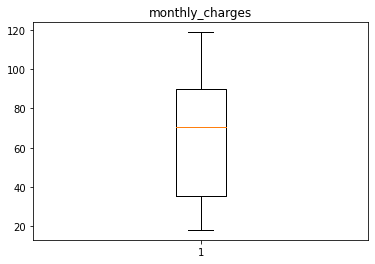

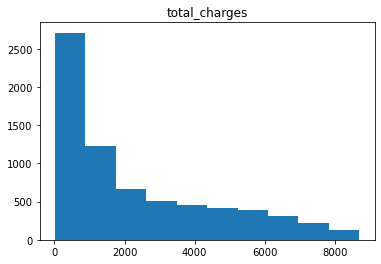

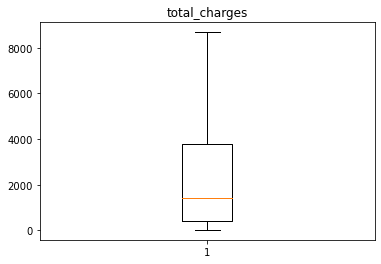

In [21]:
# Plot numeric columns
num_cols = df.columns[[(df[col].dtype == 'int64') or (df[col].dtype == 'float64') for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

In [22]:
# Use .describe with object columns
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [23]:
for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')

CUSTOMER_ID
Count:
9933-QRGTX    1
5766-XQXMQ    1
2931-XIQBR    1
6142-VSJQO    1
4274-DRSQT    1
             ..
7893-IXHRQ    1
0661-XEYAN    1
7683-CBDKJ    1
3662-FXJFO    1
0607-MVMGC    1
Name: customer_id, Length: 7032, dtype: int64


Proportions:
9933-QRGTX    0.000142
5766-XQXMQ    0.000142
2931-XIQBR    0.000142
6142-VSJQO    0.000142
4274-DRSQT    0.000142
                ...   
7893-IXHRQ    0.000142
0661-XEYAN    0.000142
7683-CBDKJ    0.000142
3662-FXJFO    0.000142
0607-MVMGC    0.000142
Name: customer_id, Length: 7032, dtype: float64
--------------------------


GENDER
Count:
Male      3549
Female    3483
Name: gender, dtype: int64


Proportions:
Male      0.504693
Female    0.495307
Name: gender, dtype: float64
--------------------------


PARTNER
Count:
No     3639
Yes    3393
Name: partner, dtype: int64


Proportions:
No     0.517491
Yes    0.482509
Name: partner, dtype: float64
--------------------------


DEPENDENTS
Count:
No     4933
Yes    2099
Name: dependents,

## PREPARE DATA

- Now that we have elminated redundant and unhelpful columns, the remaining object columns must be encoded into values in order for the classification algorithms to function.

- Columns with only two possible choices can be represented as wither a 1 or a 0.

In [24]:
# encode binary categorical variables into numeric values
df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})

In [25]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.90,No,Two year,DSL,Mailed check,1,1,1,1,1,0
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic),0,0,0,0,0,0
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic),1,0,0,0,0,0
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.40,No,Two year,DSL,Credit card (automatic),0,1,1,0,1,0
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic),0,1,0,1,1,0


In [26]:
# Drop the original object columns these values were encoded from
df.drop(columns=['gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn'], inplace=True)



In [27]:
#Confirm columns dropped

df.head()

,customer_id,senior_citizen,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded
0,0016-QLJIS,0,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.90,Two year,DSL,Mailed check,1,1,1,1,1,0
1,0017-DINOC,0,54,No phone service,Yes,No,No,Yes,Yes,No,45.20,2460.55,Two year,DSL,Credit card (automatic),0,0,0,0,0,0
2,0019-GFNTW,0,56,No phone service,Yes,Yes,Yes,Yes,No,No,45.05,2560.10,Two year,DSL,Bank transfer (automatic),1,0,0,0,0,0
3,0056-EPFBG,0,20,No phone service,Yes,No,Yes,Yes,No,No,39.40,825.40,Two year,DSL,Credit card (automatic),0,1,1,0,1,0
4,0078-XZMHT,0,72,Yes,No,Yes,Yes,Yes,Yes,Yes,85.15,6316.20,Two year,DSL,Bank transfer (automatic),0,1,0,1,1,0


- For object columns with more than two choices, use get dummies and one-hot encoding to represent values in columns of zeros and ones.

In [28]:
# Encode object columns with more than two choices
dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
dummy_df

,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
2,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1
7039,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1
7040,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0
7041,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1


In [29]:
# Combine newly encoded

df = pd.concat([df, dummy_df], axis=1)
df.head()

,customer_id,senior_citizen,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0016-QLJIS,0,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.90,Two year,DSL,Mailed check,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1
1,0017-DINOC,0,54,No phone service,Yes,No,No,Yes,Yes,No,45.20,2460.55,Two year,DSL,Credit card (automatic),0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
2,0019-GFNTW,0,56,No phone service,Yes,Yes,Yes,Yes,No,No,45.05,2560.10,Two year,DSL,Bank transfer (automatic),1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0056-EPFBG,0,20,No phone service,Yes,No,Yes,Yes,No,No,39.40,825.40,Two year,DSL,Credit card (automatic),0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,0078-XZMHT,0,72,Yes,No,Yes,Yes,Yes,Yes,Yes,85.15,6316.20,Two year,DSL,Bank transfer (automatic),0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0


In [30]:
df.shape

(7032, 42)

In [31]:
df.dtypes

customer_id                               object
senior_citizen                             int64
tenure                                     int64
multiple_lines                            object
online_security                           object
online_backup                             object
device_protection                         object
tech_support                              object
streaming_tv                              object
streaming_movies                          object
monthly_charges                          float64
total_charges                            float64
contract_type                             object
internet_service_type                     object
payment_type                              object
gender_encoded                             int64
partner_encoded                            int64
dependents_encoded                         int64
phone_service_encoded                      int64
paperless_billing_encoded                  int64
churn_encoded       

In [32]:
# Drop the redundant newly encoded columns
df.drop(columns=['multiple_lines_No phone service', 'online_security_No internet service', 'online_backup_No internet service', 'device_protection_No internet service', 'tech_support_No internet service', 'streaming_tv_No internet service', 'streaming_movies_No internet service'], inplace=True)



In [33]:
df.shape

(7032, 35)

In [34]:
df.head()

,customer_id,senior_citizen,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0016-QLJIS,0,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.90,Two year,DSL,Mailed check,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1
1,0017-DINOC,0,54,No phone service,Yes,No,No,Yes,Yes,No,45.20,2460.55,Two year,DSL,Credit card (automatic),0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0
2,0019-GFNTW,0,56,No phone service,Yes,Yes,Yes,Yes,No,No,45.05,2560.10,Two year,DSL,Bank transfer (automatic),1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0
3,0056-EPFBG,0,20,No phone service,Yes,No,Yes,Yes,No,No,39.40,825.40,Two year,DSL,Credit card (automatic),0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0
4,0078-XZMHT,0,72,Yes,No,Yes,Yes,Yes,Yes,Yes,85.15,6316.20,Two year,DSL,Bank transfer (automatic),0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0


In [35]:
# Drop the original object columns these values were encoded from

df.drop(columns=['multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'internet_service_type', 'payment_type'], inplace=True)


## Feature Engineering

- Are there any interesting or informative new features we can envision or encode that may have predictive value?
- May be useful, may not, won't know until we try
- Will comment out for now. Create models with base fields and then add these to see if models improve if time permits.

In [36]:
#Confirm columns dropped

df.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0016-QLJIS,0,65,90.45,5957.90,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1
1,0017-DINOC,0,54,45.20,2460.55,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0
2,0019-GFNTW,0,56,45.05,2560.10,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0
3,0056-EPFBG,0,20,39.40,825.40,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0
4,0078-XZMHT,0,72,85.15,6316.20,0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0


In [37]:
df.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0016-QLJIS,0,65,90.45,5957.90,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1
1,0017-DINOC,0,54,45.20,2460.55,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0
2,0019-GFNTW,0,56,45.05,2560.10,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0
3,0056-EPFBG,0,20,39.40,825.40,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0
4,0078-XZMHT,0,72,85.15,6316.20,0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0


## Splitting

- Now that we have imported, cleaned, and prepared our data, we can split it into train, validate, and test dataframes.

In [38]:
train_validate, telco_test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn_encoded)

telco_train, telco_validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn_encoded)

In [39]:
print(telco_train.shape)
print(telco_validate.shape)
print(telco_test.shape)

(3937, 25)
(1688, 25)
(1407, 25)


### Turn the above steps into functions

- Standardize preparation making it repeatable

In [40]:
from env import host, user, password


def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


In [41]:

###################### Acquire Telco Data ######################


def new_telco_data():
    '''
    This function reads the telco data from the Codeup database into a dataframe.
    '''
    sql_query = '''
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                '''
    
    # Read in DataFrame from Codeup db.
    telco_df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return telco_df


In [42]:

def get_telco_data():
    '''
    This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a dataframe.
    '''
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        telco_df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        telco_df = new_telco_data()
        
        # Cache data
        telco_df.to_csv('telco.csv')
        
    return telco_df

In [43]:
def prep_telco_data(df):
    # Drop duplicates
    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'], inplace=True)
       
    # Drop null values
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    # Convert datatype
    df['total_charges'] = df.total_charges.astype(float)
    
    # Convert boolean columns to ones and zeroes
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Drop the original object columns these values were encoded from
    df.drop(columns=['gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn'], inplace=True)
    
    # Get dummies categorical variables with more than two choices
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True) 
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)

    # Drop the redundant newly encoded columns
    df.drop(columns=['multiple_lines_No phone service', 'online_security_No internet service', 'online_backup_No internet service', 'device_protection_No internet service', 'tech_support_No internet service', 'streaming_tv_No internet service', 'streaming_movies_No internet service'], inplace=True)

    df.drop(columns=['multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'internet_service_type', 'payment_type'], inplace=True)
    
    return df

In [44]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, telco_test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn_encoded)
    telco_train, telco_validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn_encoded)
    return telco_train, telco_validate, telco_test

In [45]:
def wrangle_telco():
    telco_df = get_telco_data()
    telco_df = prep_telco_data(telco_df)
    telco_train, telco_validate, telco_test = split_telco_data(telco_df)
    # Cache data
    telco_df.to_csv('telco_wrangled.csv')
    telco_train.to_csv('telco_train_wrangled.csv')
    return telco_train, telco_validate, telco_test

In [46]:
telco_df = get_telco_data()
telco_df.head()


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [47]:
telco_df.shape

(7043, 24)

In [48]:
telco_df = prep_telco_data(telco_df)
telco_df.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0016-QLJIS,0,65,90.45,5957.90,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1
1,0017-DINOC,0,54,45.20,2460.55,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0
2,0019-GFNTW,0,56,45.05,2560.10,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0
3,0056-EPFBG,0,20,39.40,825.40,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0
4,0078-XZMHT,0,72,85.15,6316.20,0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0


In [49]:
telco_df.shape

(7032, 25)

In [50]:
# Do everything we did above in one line

telco_train, telco_validate, telco_test= wrangle_telco()

In [51]:
# Confirm it worked

print(telco_train.shape)
print(telco_validate.shape)
print(telco_test.shape)

(3937, 25)
(1688, 25)
(1407, 25)


---

# Exploratory Data Analysis

In [52]:
telco_train.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,8966-SNIZF,0,70,19.45,1303.50,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1603,3466-BYAVD,0,15,69.50,1071.40,0,1,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1
5350,9278-VZKCD,1,52,109.10,5647.95,1,1,0,1,1,0,1,1,1,1,0,1,1,0,0,1,0,0,1,0
2068,7074-STDCN,0,39,40.60,1494.50,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6366,5914-GXMDA,0,32,19.30,593.20,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [53]:
telco_train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3937.0,0.164338,0.370629,0.00,0.00,0.00,0.00,1.00
tenure,3937.0,32.505715,24.773712,1.00,8.00,29.00,56.00,72.00
monthly_charges,3937.0,64.191046,30.129425,18.55,34.95,69.95,89.45,118.75
total_charges,3937.0,2281.487668,2287.371123,18.80,371.40,1359.70,3827.90,8684.80
gender_encoded,3937.0,0.491491,0.499991,0.00,0.00,0.00,1.00,1.00
partner_encoded,3937.0,0.483617,0.499795,0.00,0.00,0.00,1.00,1.00
dependents_encoded,3937.0,0.297943,0.457412,0.00,0.00,0.00,1.00,1.00
phone_service_encoded,3937.0,0.901194,0.298440,0.00,1.00,1.00,1.00,1.00
paperless_billing_encoded,3937.0,0.589027,0.492073,0.00,0.00,1.00,1.00,1.00
churn_encoded,3937.0,0.265685,0.441753,0.00,0.00,0.00,1.00,1.00


In [54]:
def object_vals(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(df[col].value_counts(dropna=False))

In [55]:
# Write a column that calculates the range in values

def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [56]:
# Create a function to summarize my df

def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('------------------------')
    print(df.info())
    print('------------------------')
    print(df.head())
    print('------------------------')
    object_vals(df)
    print('------------------------')
    print(col_range(df))

In [57]:
summarize_df(telco_train)


This dataframe has 3937 rows and 25 columns.
------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 6096 to 3935
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   customer_id                           3937 non-null   object 
 1   senior_citizen                        3937 non-null   int64  
 2   tenure                                3937 non-null   int64  
 3   monthly_charges                       3937 non-null   float64
 4   total_charges                         3937 non-null   float64
 5   gender_encoded                        3937 non-null   int64  
 6   partner_encoded                       3937 non-null   int64  
 7   dependents_encoded                    3937 non-null   int64  
 8   phone_service_encoded                 3937 non-null   int64  
 9   paperless_billing_encoded             3937 non-null   int64  
 10  churn_encod

---

## Exploratory Vizualizations

- Plot some relationships to see if any trends jump out at us

In [58]:
# Configure plots

import seaborn as sns


plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))

In [59]:
melted = telco_train.melt(id_vars=['churn_encoded'])


In [60]:
melted.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94488 entries, 0 to 94487
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   churn_encoded  94488 non-null  int64 
 1   variable       94488 non-null  object
 2   value          94488 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [61]:
melted

,churn_encoded,variable,value
0,0,customer_id,8966-SNIZF
1,0,customer_id,3466-BYAVD
2,0,customer_id,9278-VZKCD
3,0,customer_id,7074-STDCN
4,0,customer_id,5914-GXMDA
...,...,...,...
94483,0,payment_type_Mailed check,0
94484,1,payment_type_Mailed check,0
94485,0,payment_type_Mailed check,0
94486,0,payment_type_Mailed check,0


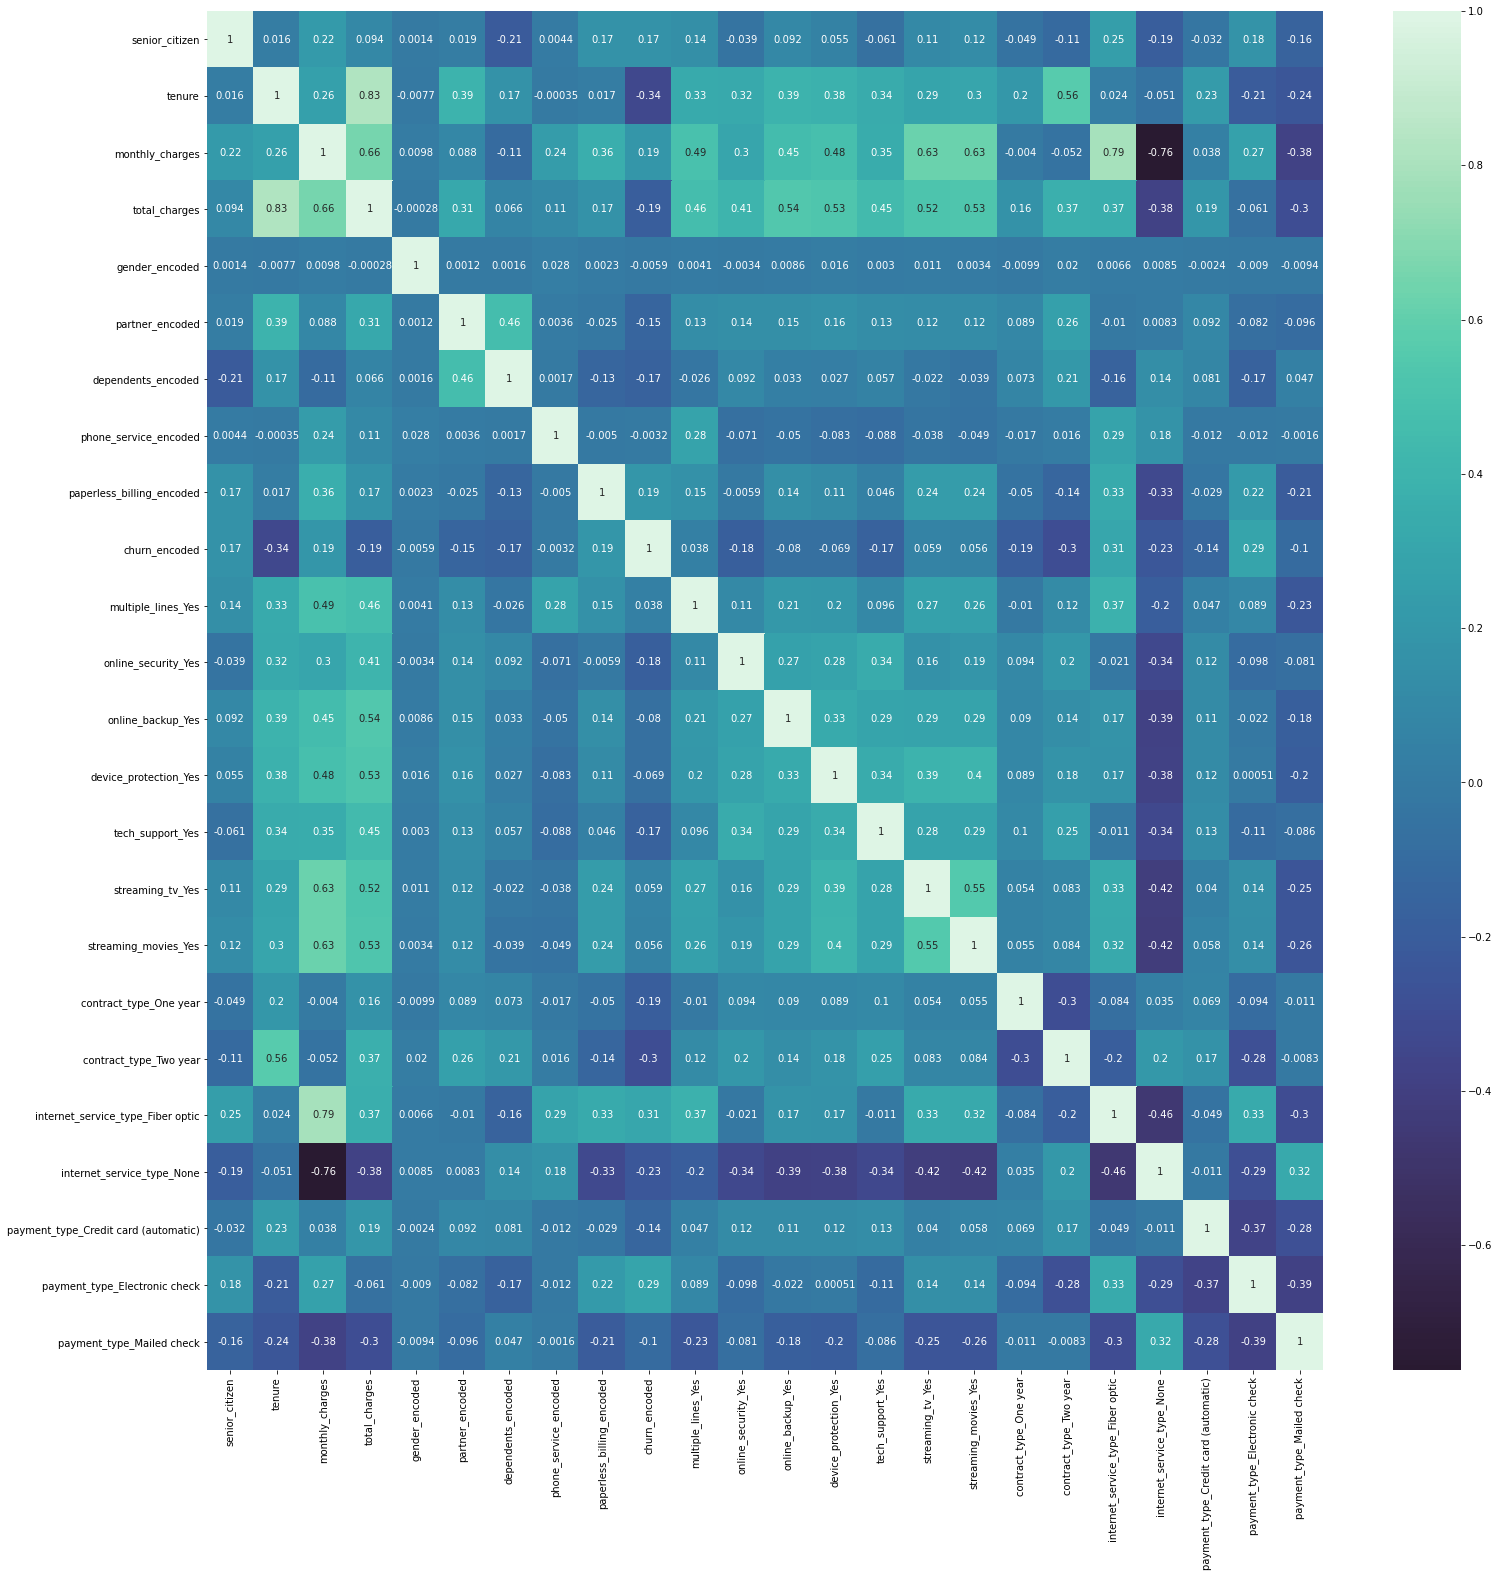

In [62]:
# Visuualize heatmap of variable correlations


plt.rc('font', size=10)
plt.rc('figure', figsize=(25, 25))

sns.heatmap(telco_train.corr(), cmap='mako', center=0, annot=True)

plt.title('')
plt.show()

In [ ]:
sns.pairplot(telco_train, corner='True',  hue='churn_encoded')
plt.show()

Looking at correlations in the churn row, pairise relationships potentially worth exploring include:
- Paperless billing
- Tenure
- Senior Citizen
- No internet service
- Fiber Optic Service
- Electronic check

In [63]:
# Set 95% confidence alpha

alpha = 0.05

In [64]:
# Split data based on whether or not the customers churned

churn = telco_train[telco_train['churn_encoded'] == 1]
no_churn = telco_train[telco_train['churn_encoded'] == 0]

In [65]:
churn.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6947,7989-CHGTL,0,1,19.60,19.6,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6791,4877-EVATK,0,1,20.00,20.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3879,2379-ENZGV,0,6,84.85,523.5,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3474,0378-TOVMS,0,3,85.80,272.2,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4594,5519-NPHVG,0,12,94.20,1046.1,1,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0


In [66]:
no_churn.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,8966-SNIZF,0,70,19.45,1303.50,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1603,3466-BYAVD,0,15,69.50,1071.40,0,1,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1
5350,9278-VZKCD,1,52,109.10,5647.95,1,1,0,1,1,0,1,1,1,1,0,1,1,0,0,1,0,0,1,0
2068,7074-STDCN,0,39,40.60,1494.50,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6366,5914-GXMDA,0,32,19.30,593.20,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [67]:
print(churn.shape)
print(no_churn.shape)

(1046, 25)
(2891, 25)


In [68]:
telco_train.churn_encoded.value_counts()


0    2891
1    1046
Name: churn_encoded, dtype: int64

Text(0.5, 0, 'Churned')

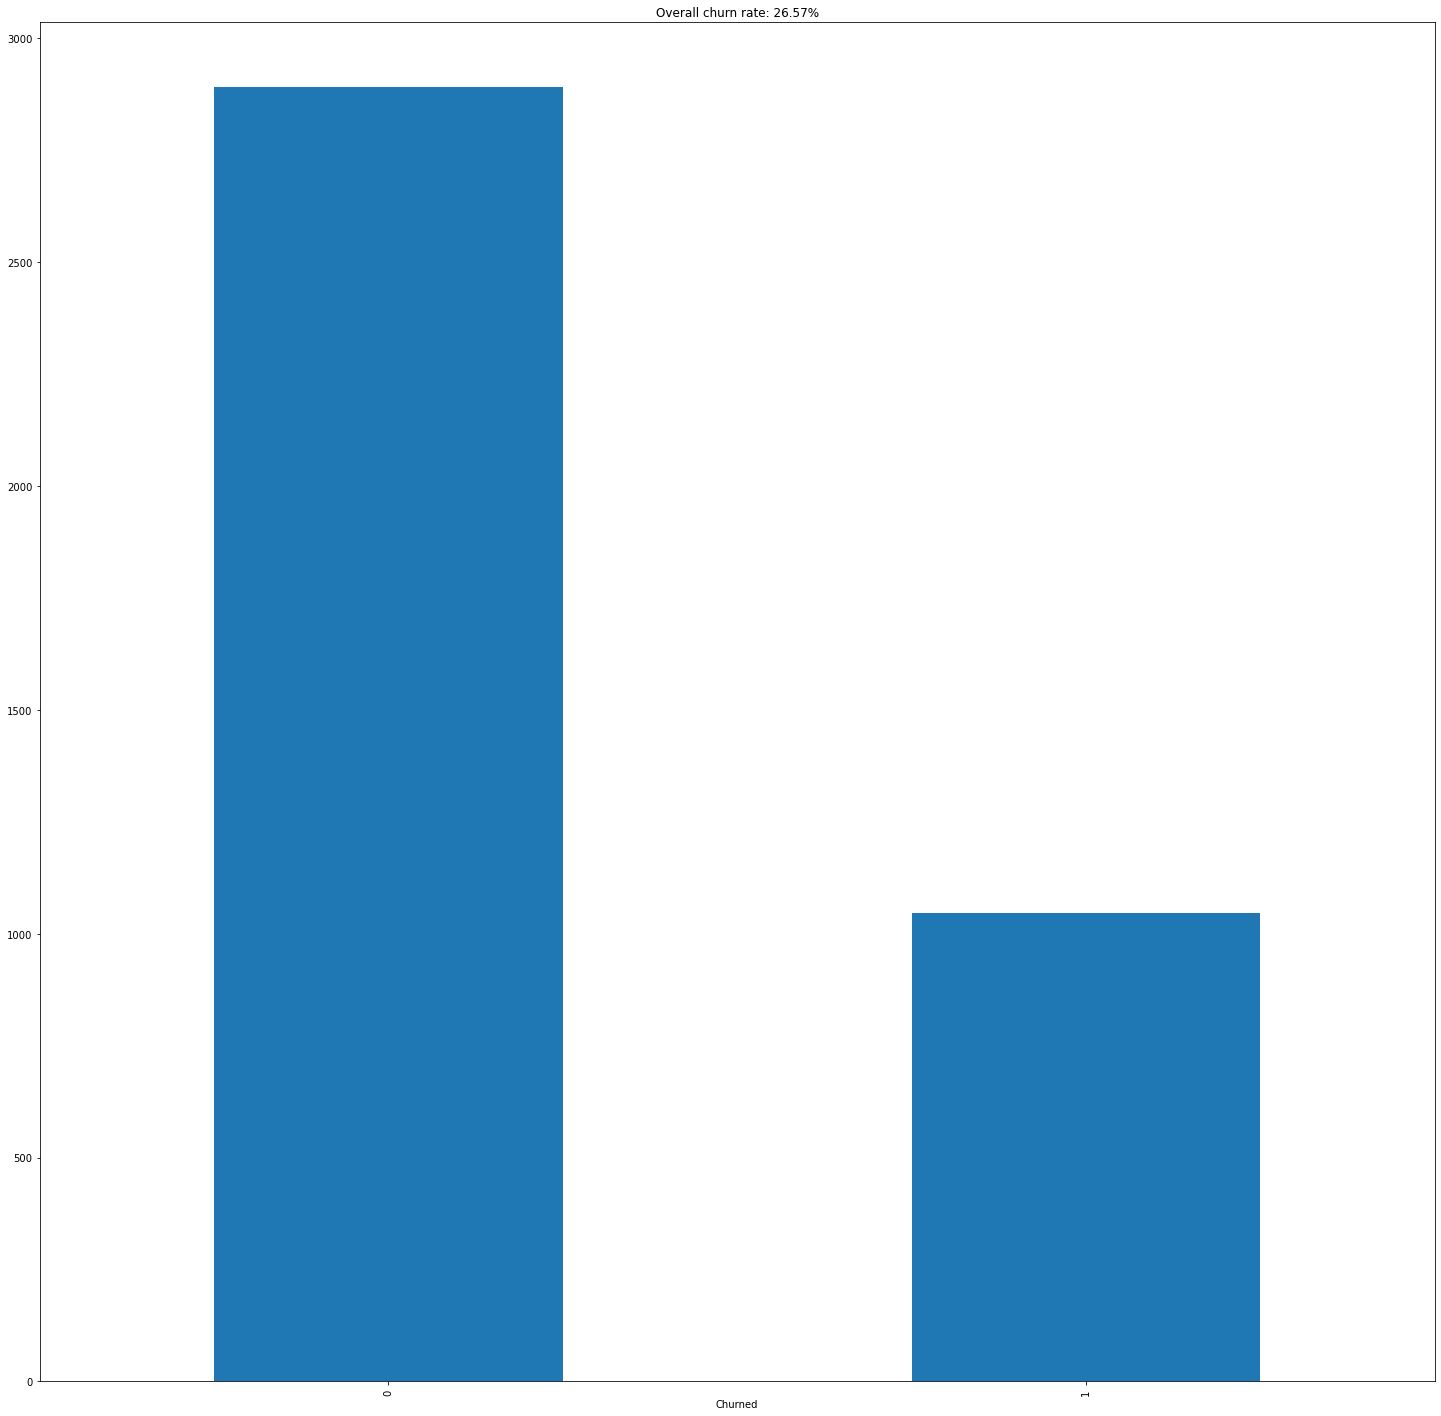

In [69]:
telco_train.churn_encoded.value_counts().sort_index().plot.bar()
churn_rate = telco_train.churn_encoded.mean()
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churned')

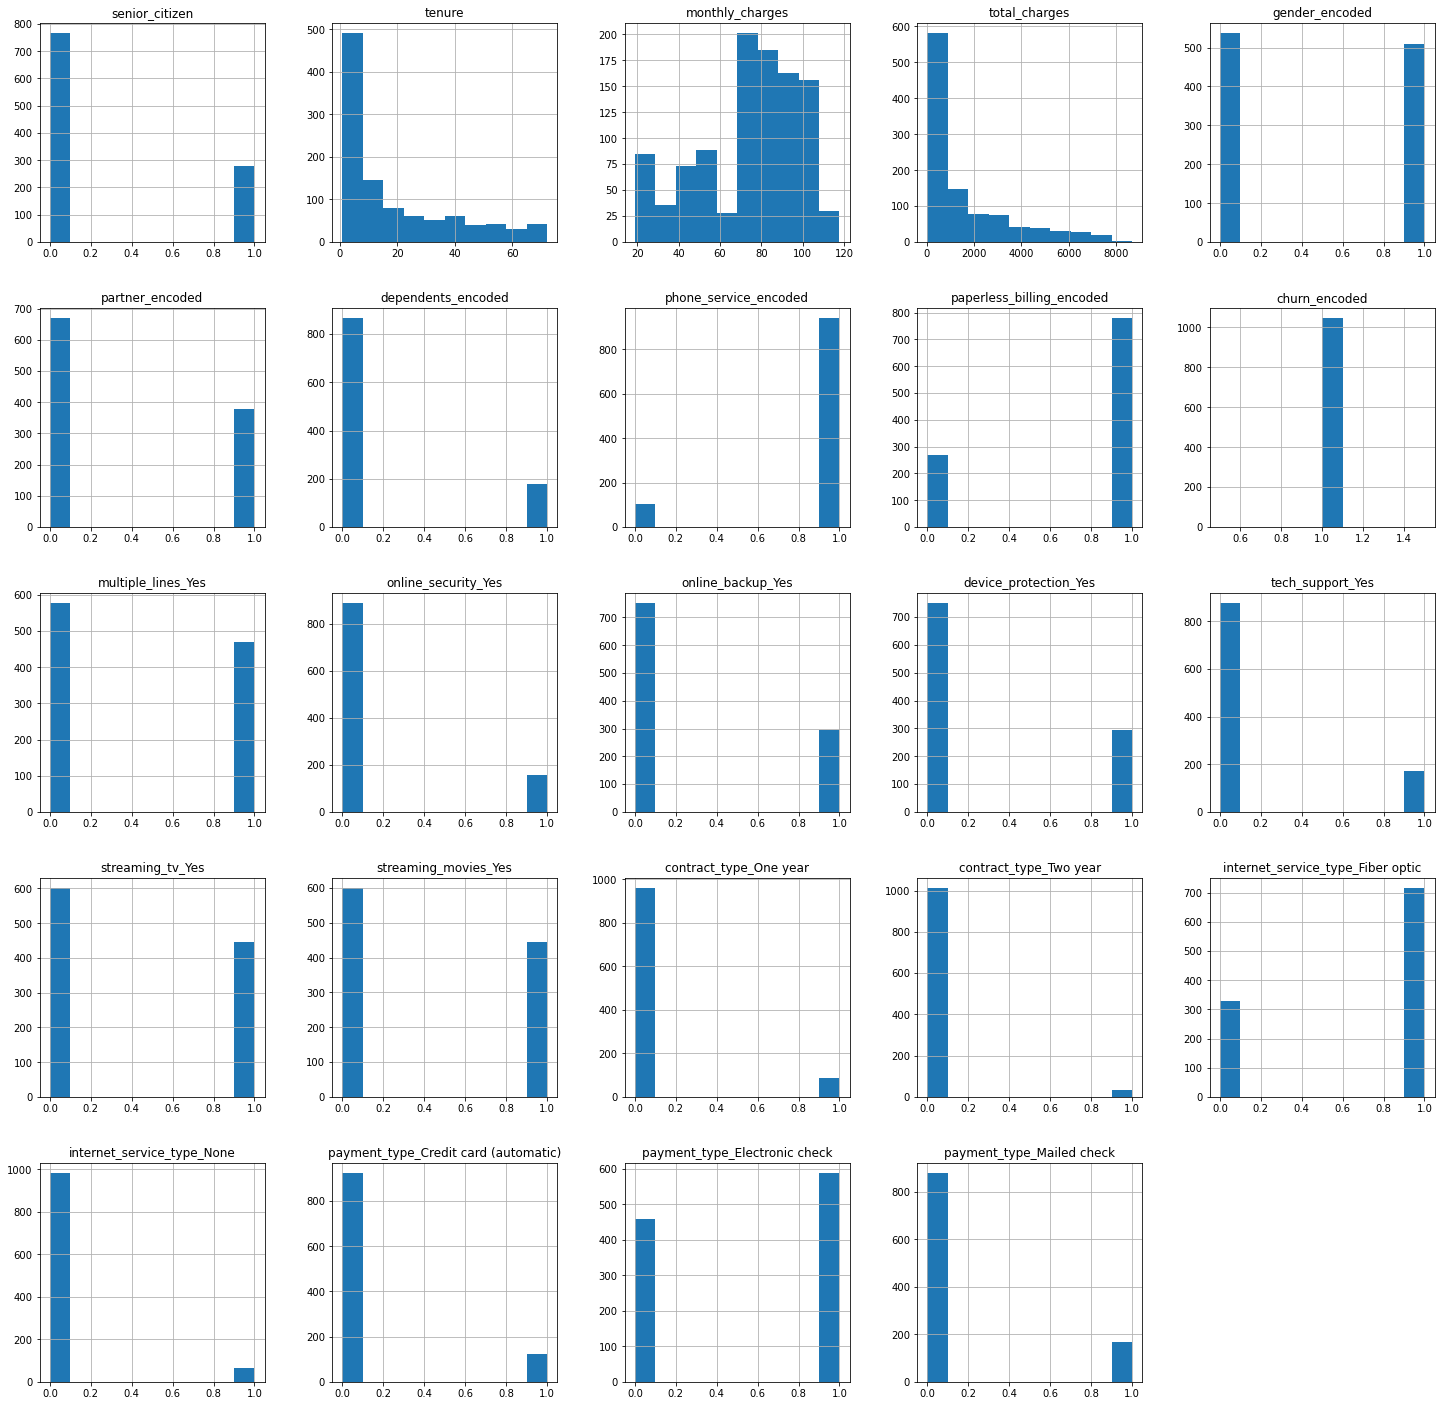

In [70]:
churn.hist();

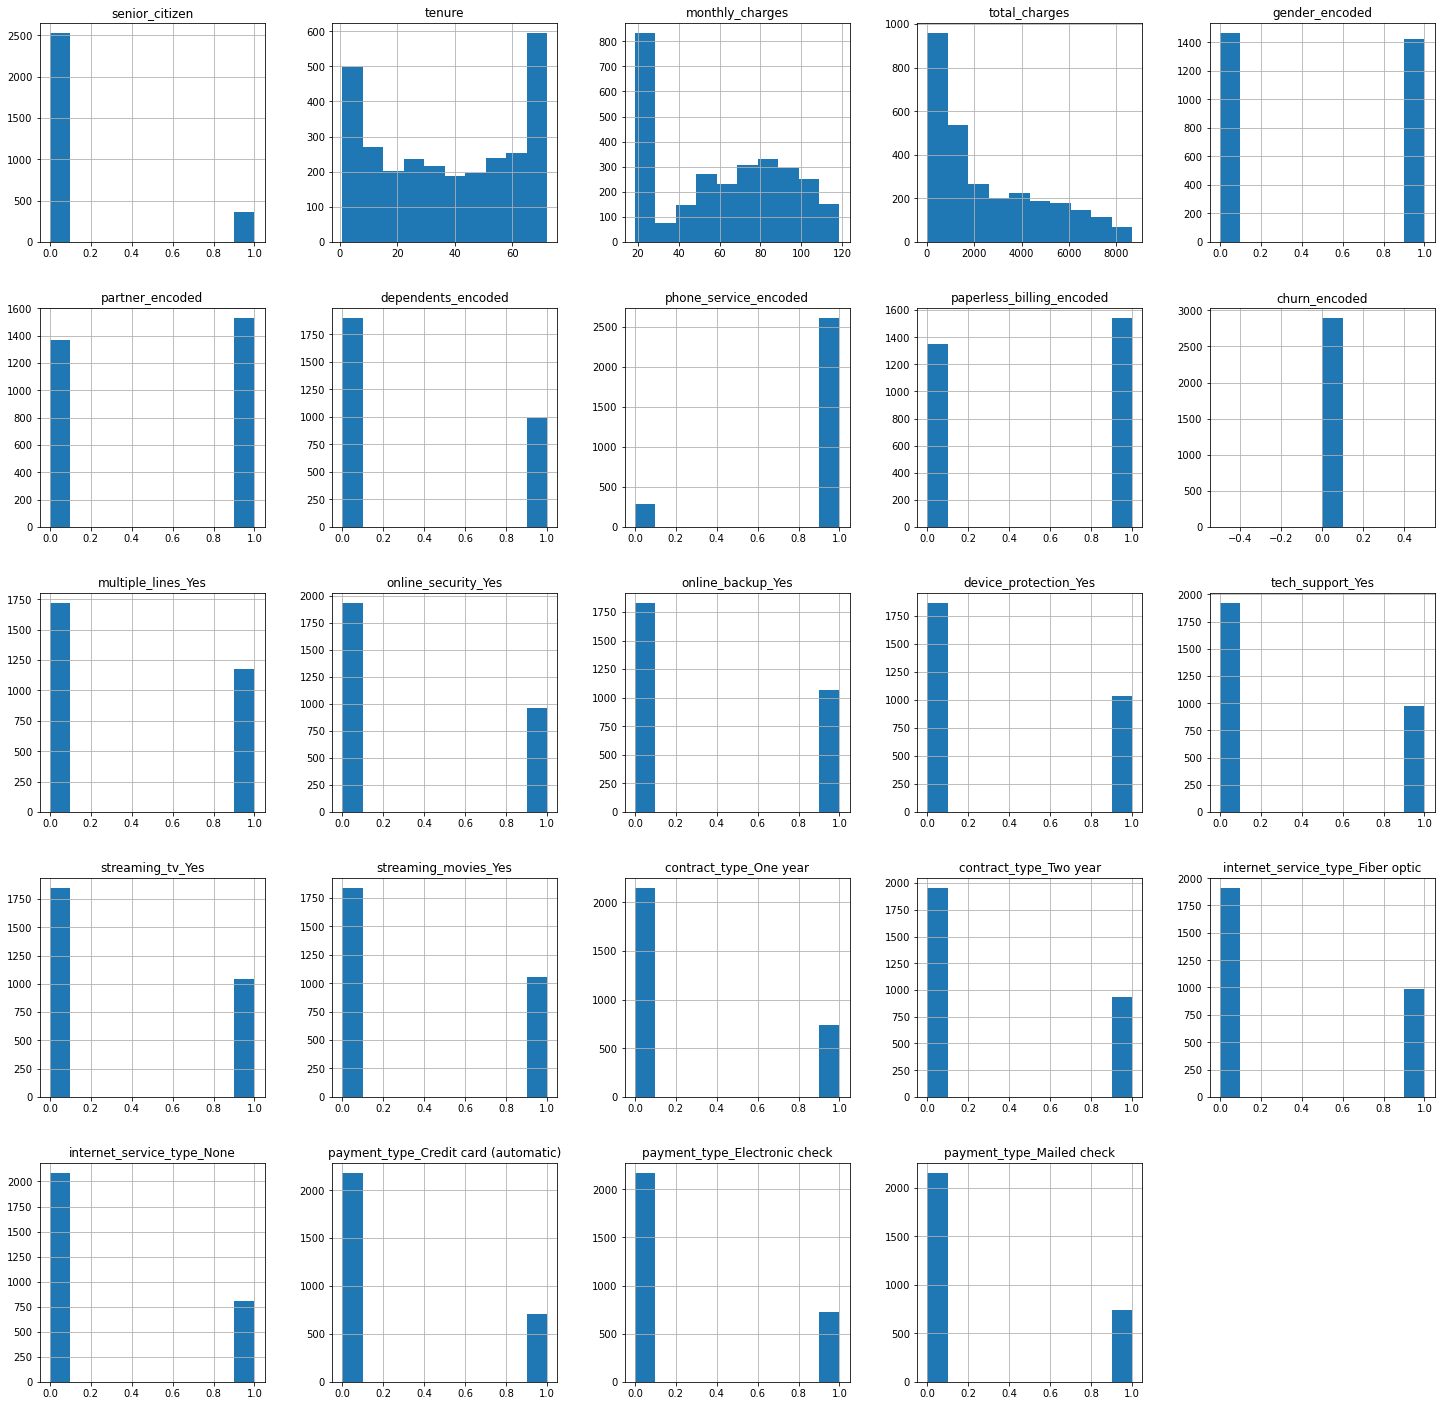

In [71]:
no_churn.hist();

In [72]:
churn_stat = churn.describe().T

In [73]:
no_churn_stat = no_churn.describe().T

In [74]:
# Look at the differences in means and other stats between customers who did and did not churn

diff_stat = no_churn_stat - churn_stat
diff_stat

,count,mean,std,min,25%,50%,75%,max
senior_citizen,1845.0,-0.140741,-0.109995,0.00,0.000,0.000,-1.000,0.00
tenure,1845.0,19.112216,4.260877,0.00,12.000,27.000,30.250,0.00
monthly_charges,1845.0,-12.898246,6.231542,-0.30,-30.200,-15.525,-7.400,0.95
total_charges,1845.0,999.651111,421.330572,-0.05,435.225,985.375,1890.075,-12.35
gender_encoded,1845.0,0.006639,-0.000019,0.00,0.000,0.000,0.000,0.00
partner_encoded,1845.0,0.167770,0.018939,0.00,0.000,1.000,0.000,0.00
dependents_encoded,1845.0,0.171396,0.097318,0.00,0.000,0.000,1.000,0.00
phone_service_encoded,1845.0,0.002147,-0.002968,0.00,0.000,0.000,0.000,0.00
paperless_billing_encoded,1845.0,-0.212054,0.062802,0.00,0.000,0.000,0.000,0.00
churn_encoded,1845.0,-1.000000,0.000000,-1.00,-1.000,-1.000,-1.000,-1.00


In [75]:
# Biggest factors for churn

diff_stat.sort_values('mean').head(7)

,count,mean,std,min,25%,50%,75%,max
monthly_charges,1845.0,-12.898246,6.231542,-0.3,-30.2,-15.525,-7.4,0.95
churn_encoded,1845.0,-1.000000,0.000000,-1.0,-1.0,-1.000,-1.0,-1.00
internet_service_type_Fiber optic,1845.0,-0.344838,0.008749,0.0,0.0,-1.000,0.0,0.00
payment_type_Electronic check,1845.0,-0.312055,-0.063223,0.0,0.0,-1.000,-0.5,0.00
paperless_billing_encoded,1845.0,-0.212054,0.062802,0.0,0.0,0.000,0.0,0.00
senior_citizen,1845.0,-0.140741,-0.109995,0.0,0.0,0.000,-1.0,0.00
streaming_tv_Yes,1845.0,-0.064309,-0.014236,0.0,0.0,0.000,0.0,0.00


In [76]:
# Biggest factors for remain

diff_stat.sort_values('mean').tail(7)

,count,mean,std,min,25%,50%,75%,max
tech_support_Yes,1845.0,0.173692,0.103388,0.00,0.000,0.000,1.000,0.00
contract_type_One year,1845.0,0.175132,0.162422,0.00,0.000,0.000,1.000,0.00
online_security_Yes,1845.0,0.181359,0.112888,0.00,0.000,0.000,1.000,0.00
internet_service_type_None,1845.0,0.217957,0.208870,0.00,0.000,0.000,1.000,0.00
contract_type_Two year,1845.0,0.291950,0.290831,0.00,0.000,0.000,1.000,0.00
tenure,1845.0,19.112216,4.260877,0.00,12.000,27.000,30.250,0.00
total_charges,1845.0,999.651111,421.330572,-0.05,435.225,985.375,1890.075,-12.35


Again, these factors seem to correlate with higher churn:
- Fiber optic
- Monthly Charges
- Electronic check
- Senior citizen 

These factors seem to reduce churn:
- One-year contract 
- Two-year contract
- No internet

These don't seem to matter much:
- Gender
- Streaming tv
- Phone Service

In [77]:
import scipy.stats as stats

conf_interval = 0.95
alpha = 1 - conf_interval


In [78]:
churn.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6947,7989-CHGTL,0,1,19.60,19.6,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6791,4877-EVATK,0,1,20.00,20.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3879,2379-ENZGV,0,6,84.85,523.5,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3474,0378-TOVMS,0,3,85.80,272.2,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4594,5519-NPHVG,0,12,94.20,1046.1,1,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0


In [79]:
churn.dtypes

customer_id                              object
senior_citizen                            int64
tenure                                    int64
monthly_charges                         float64
total_charges                           float64
gender_encoded                            int64
partner_encoded                           int64
dependents_encoded                        int64
phone_service_encoded                     int64
paperless_billing_encoded                 int64
churn_encoded                             int64
multiple_lines_Yes                        uint8
online_security_Yes                       uint8
online_backup_Yes                         uint8
device_protection_Yes                     uint8
tech_support_Yes                          uint8
streaming_tv_Yes                          uint8
streaming_movies_Yes                      uint8
contract_type_One year                    uint8
contract_type_Two year                    uint8
internet_service_type_Fiber optic       

### Things that increase churn

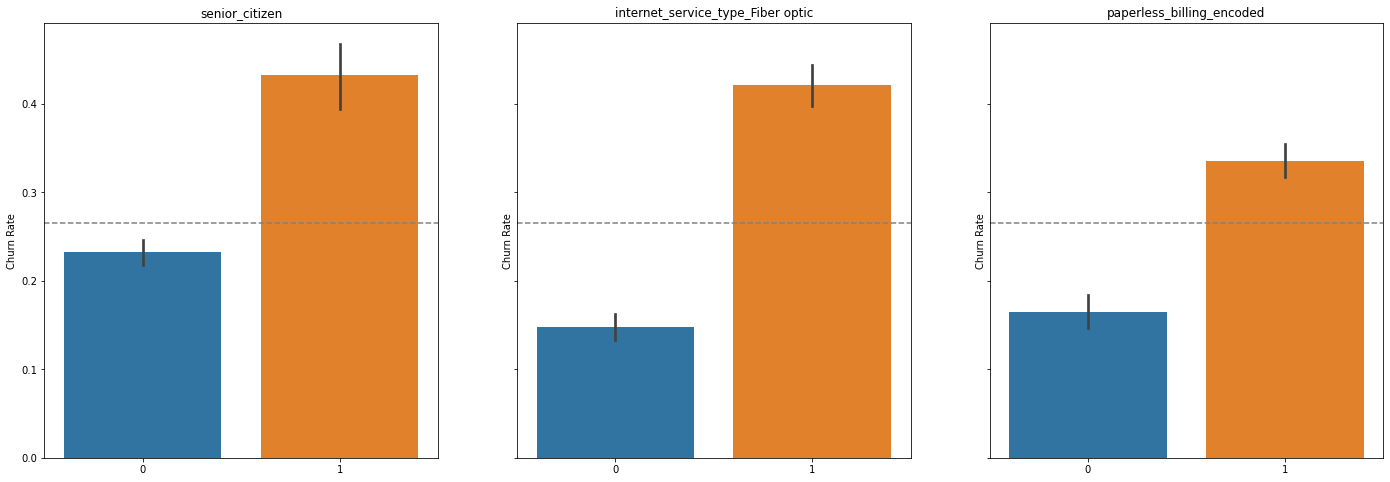

In [80]:
features = ['senior_citizen', 'internet_service_type_Fiber optic',  'paperless_billing_encoded']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=telco_train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Things that Decrease churn

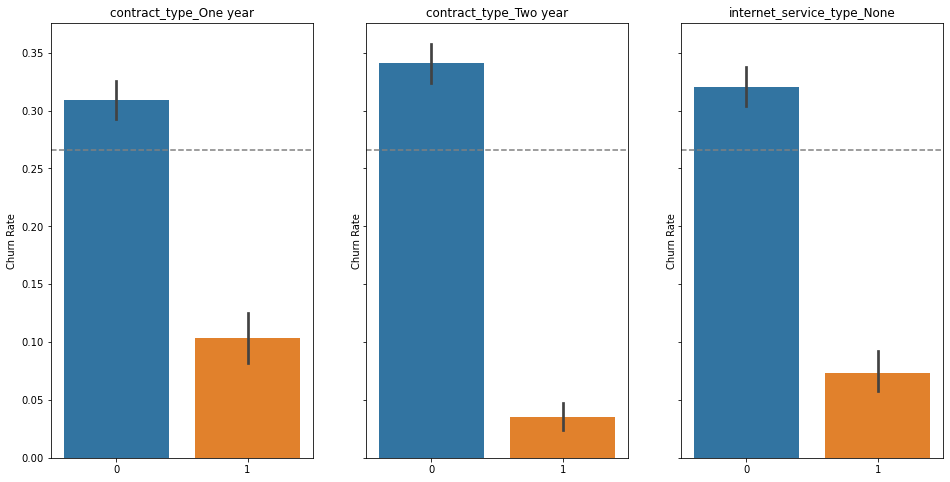

In [81]:
features = ['contract_type_One year', 'contract_type_Two year', 'internet_service_type_None']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=telco_train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Things that dont matter

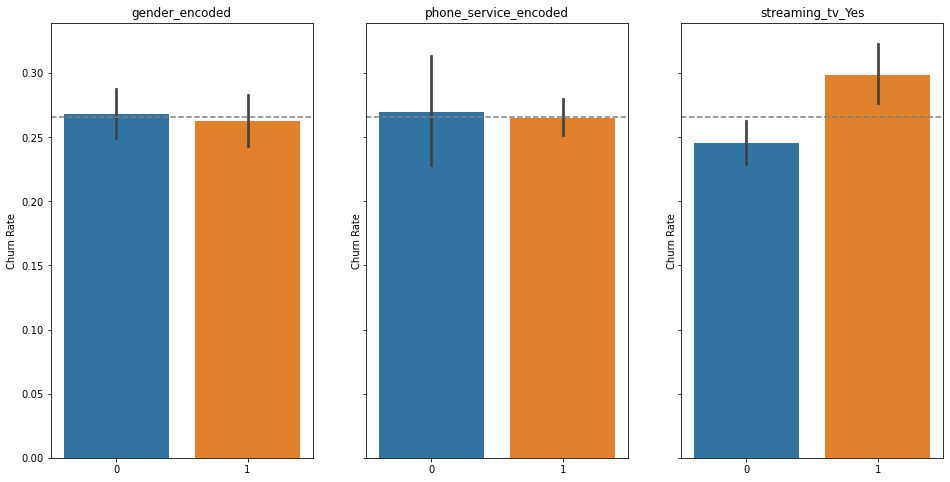

In [82]:
features = ['gender_encoded','phone_service_encoded', 'streaming_tv_Yes']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=telco_train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

---

## Statistical Tests

### Do seniors churn at a different rate?

$H_0$: Churn independent of senior status

$H_1$: Churn dependent on senior status

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [83]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Senior=1', 'Senior=0']

senior_observed = pd.DataFrame([[churn.senior_citizen.value_counts()[1], churn.senior_citizen.value_counts()[0]], [no_churn.senior_citizen.value_counts()[1], no_churn.senior_citizen.value_counts()[0]]], index=index, columns=columns)
senior_observed


,Senior=1,Senior=0
Churn,280,766
No Churn,367,2524


In [84]:
senior_chi2, senior_p, senior_degf, senior_expected = stats.chi2_contingency(senior_observed)

print('Observed\n')
print(senior_observed.values)
print('---\nExpected\n')
print(senior_expected)
print('---\n')
print(f'chi^2 = {senior_chi2:.4f}')
print(f'p     = {senior_p:.4f}')
if senior_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 280  766]
 [ 367 2524]]
---
Expected

[[ 171.8978918  874.1021082]
 [ 475.1021082 2415.8978918]]
---

chi^2 = 109.7635
p     = 0.0000
We can reject the null hypothesis


### Are churn and fiber optic independent?

$H_0$: Churn and fiber optic internet are independent

$H_1$: Churn and Fiber are dependent

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [85]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Fiber=1', 'Fiber=0']

fiber_observed = pd.DataFrame([[716, 330], [982, 1901]], index=index, columns=columns)
fiber_observed

,Fiber=1,Fiber=0
Churn,716,330
No Churn,982,1901


In [86]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Fiber=1', 'Fiber=0']

fiber_observed = pd.DataFrame([[churn['internet_service_type_Fiber optic'].value_counts()[1], churn['internet_service_type_Fiber optic'].value_counts()[0]], [no_churn['internet_service_type_Fiber optic'].value_counts()[1], no_churn['internet_service_type_Fiber optic'].value_counts()[0]]], index=index, columns=columns)
fiber_observed

,Fiber=1,Fiber=0
Churn,716,330
No Churn,982,1909


In [87]:
fiber_chi2, fiber_p, fiber_degf, fiber_expected = stats.chi2_contingency(fiber_observed)

print('Observed\n')
print(fiber_observed.values)
print('---\nExpected\n')
print(fiber_expected)
print('---\n')
print(f'chi^2 = {fiber_chi2:.4f}')
print(f'p     = {fiber_p:.4f}')
if fiber_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 716  330]
 [ 982 1909]]
---
Expected

[[ 451.13233426  594.86766574]
 [1246.86766574 1644.13233426]]
---

chi^2 = 370.9722
p     = 0.0000
We can reject the null hypothesis


### Do people with paperless billing churn at a different rate

$H_0$: churn and paperless independent

$H_1$: churn and paperless not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [88]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Paperless=1', 'Paperless=0']

paperless_observed = pd.DataFrame([[churn.paperless_billing_encoded.value_counts()[1], churn.paperless_billing_encoded.value_counts()[0]], [no_churn.paperless_billing_encoded.value_counts()[1], no_churn.paperless_billing_encoded.value_counts()[0]]], index=index, columns=columns)
paperless_observed

,Paperless=1,Paperless=0
Churn,779,267
No Churn,1540,1351


In [89]:
paperless_chi2, paperless_p, paperless_degf, paperless_expected = stats.chi2_contingency(paperless_observed)

print('Observed\n')
print(paperless_observed.values)
print('---\nExpected\n')
print(paperless_expected)
print('---\n')
print(f'chi^2 = {paperless_chi2:.4f}')
print(f'p     = {paperless_p:.4f}')
if paperless_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 779  267]
 [1540 1351]]
---
Expected

[[ 616.12242824  429.87757176]
 [1702.87757176 1188.12242824]]
---

chi^2 = 141.8043
p     = 0.0000
We can reject the null hypothesis


---

## Things that decrease churn

The Following items seemed to prevent churn visually, confirm throgh statistical testing.

- One-year contract
- Two-Year Contract
- Not having internet service

### Do people with a one-year contract churn at a different rate

$H_0$: churn and contract independent

$H_1$: churn and contract not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [90]:
churn['contract_type_One year'].value_counts()

0    960
1     86
Name: contract_type_One year, dtype: int64

In [91]:
no_churn['contract_type_One year'].value_counts()

0    2147
1     744
Name: contract_type_One year, dtype: int64

In [92]:
churn['contract_type_One year'].value_counts()

0    960
1     86
Name: contract_type_One year, dtype: int64

In [93]:
no_churn['contract_type_One year'].value_counts()

0    2147
1     744
Name: contract_type_One year, dtype: int64

In [94]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['One year=1', 'One Year=0']

oneyear_observed = pd.DataFrame([[churn['contract_type_One year'].value_counts()[1], churn['contract_type_One year'].value_counts()[0]], [no_churn['contract_type_One year'].value_counts()[1], no_churn['contract_type_One year'].value_counts()[0]]], index=index, columns=columns)
oneyear_observed

,One year=1,One Year=0
Churn,86,960
No Churn,744,2147


In [95]:
oneyear_chi2, oneyear_p, oneyear_degf, oneyear_expected = stats.chi2_contingency(oneyear_observed)

print('Observed\n')
print(oneyear_observed.values)
print('---\nExpected\n')
print(oneyear_expected)
print('---\n')
print(f'chi^2 = {oneyear_chi2:.4f}')
print(f'p     = {oneyear_p:.4f}')
if oneyear_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[  86  960]
 [ 744 2147]]
---
Expected

[[ 220.51816104  825.48183896]
 [ 609.48183896 2281.51816104]]
---

chi^2 = 140.5479
p     = 0.0000
We can reject the null hypothesis


### Do people with a two-year contract churn at a different rate

$H_0$: churn and contract independent

$H_1$: churn and contract not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [96]:
churn['contract_type_Two year'].value_counts()

0    1012
1      34
Name: contract_type_Two year, dtype: int64

In [97]:
no_churn['contract_type_Two year'].value_counts()

0    1953
1     938
Name: contract_type_Two year, dtype: int64

In [98]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['2 year=1', '2 Year=0']

twoyear_observed = pd.DataFrame([[churn['contract_type_Two year'].value_counts()[1], churn['contract_type_Two year'].value_counts()[1]], [no_churn['contract_type_Two year'].value_counts()[1], no_churn['contract_type_Two year'].value_counts()[0]]], index=index, columns=columns)
twoyear_observed

,2 year=1,2 Year=0
Churn,34,34
No Churn,938,1953


In [99]:
twoyear_chi2, twoyear_p, twoyear_degf, twoyear_expected = stats.chi2_contingency(twoyear_observed)

print('Observed\n')
print(twoyear_observed.values)
print('---\nExpected\n')
print(twoyear_expected)
print('---\n')
print(f'chi^2 = {twoyear_chi2:.4f}')
print(f'p     = {twoyear_p:.4f}')
if twoyear_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[  34   34]
 [ 938 1953]]
---
Expected

[[  22.33727611   45.66272389]
 [ 949.66272389 1941.33727611]]
---

chi^2 = 8.5026
p     = 0.0035
We can reject the null hypothesis


### Do people with without internet churn at a different rate

$H_0$: churn and no internet independent

$H_1$: churn and no internet not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [100]:
churn['internet_service_type_None'].value_counts()

0    982
1     64
Name: internet_service_type_None, dtype: int64

In [101]:
no_churn['internet_service_type_None'].value_counts()

0    2084
1     807
Name: internet_service_type_None, dtype: int64

In [102]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['No Internet=1', 'No Internet=0']

no_internet_observed = pd.DataFrame([[churn['internet_service_type_None'].value_counts()[1], churn['internet_service_type_None'].value_counts()[0]], [no_churn['internet_service_type_None'].value_counts()[1], no_churn['internet_service_type_None'].value_counts()[0]]], index=index, columns=columns)
no_internet_observed

,No Internet=1,No Internet=0
Churn,64,982
No Churn,807,2084


In [103]:
no_internet_chi2, no_internet_p, no_internet_degf, no_internet_expected = stats.chi2_contingency(no_internet_observed)

print('Observed\n')
print(no_internet_observed.values)
print('---\nExpected\n')
print(no_internet_expected)
print('---\n')
print(f'chi^2 = {no_internet_chi2:.4f}')
print(f'p     = {no_internet_p:.4f}')
if no_internet_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[  64  982]
 [ 807 2084]]
---
Expected

[[ 231.41122682  814.58877318]
 [ 639.58877318 2251.41122682]]
---

chi^2 = 210.5219
p     = 0.0000
We can reject the null hypothesis


---

## Stat testing things that don't look like they matter

$\Chi^2$ is sometimes most interesting when it is telling us there is a difference, but can also be quite useful to confirm our suspictions that there is no difference and identify irrelevant columns which can be excluded form our model without adverserly impacting the results

Here are some things that visually don't seem to matter, lets confirm:

- Gender
- Phone Service (yes/no)
- Streamint TV (yes/no)

## Does gender influence churn rate?

$H_0$: churn and gender independent

$H_1$: churn and gender not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [104]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Gender=1', 'Gender=0']

gender_observed = pd.DataFrame([[churn.gender_encoded.value_counts()[1], churn.gender_encoded.value_counts()[0]], [no_churn.gender_encoded.value_counts()[1], no_churn.gender_encoded.value_counts()[0]]], index=index, columns=columns)
gender_observed

,Gender=1,Gender=0
Churn,509,537
No Churn,1426,1465


In [105]:
gender_chi2, gender_p, gender_degf, gender_expected = stats.chi2_contingency(gender_observed)

print('Observed\n')
print(gender_observed.values)
print('---\nExpected\n')
print(gender_expected)
print('---\n')
print(f'chi^2 = {gender_chi2:.4f}')
print(f'p     = {gender_p:.4f}')
if gender_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 509  537]
 [1426 1465]]
---
Expected

[[ 514.0995682  531.9004318]
 [1420.9004318 1470.0995682]]
---

chi^2 = 0.1102
p     = 0.7399
We fail to reject the null hypothesis


## Does phone service churn rate?

$H_0$: churn and phone service independent

$H_1$: churn and phone service not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [106]:
churn.phone_service_encoded.value_counts()

1    941
0    105
Name: phone_service_encoded, dtype: int64

In [107]:
no_churn.phone_service_encoded.value_counts()

1    2607
0     284
Name: phone_service_encoded, dtype: int64

In [108]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Phone=1', 'Phone=0']

phone_observed = pd.DataFrame([[churn.phone_service_encoded.value_counts()[1], churn.phone_service_encoded.value_counts()[0]], [no_churn.phone_service_encoded.value_counts()[1], no_churn.phone_service_encoded.value_counts()[0]]], index=index, columns=columns)
phone_observed

,Phone=1,Phone=0
Churn,941,105
No Churn,2607,284


In [109]:
phone_chi2, phone_p, phone_degf, phone_expected = stats.chi2_contingency(phone_observed)

print('Observed\n')
print(phone_observed.values)
print('---\nExpected\n')
print(phone_expected)
print('---\n')
print(f'chi^2 = {phone_chi2:.4f}')
print(f'p     = {phone_p:.4f}')
if phone_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 941  105]
 [2607  284]]
---
Expected

[[ 942.6487173  103.3512827]
 [2605.3512827  285.6487173]]
---

chi^2 = 0.0193
p     = 0.8895
We fail to reject the null hypothesis


## Does streaming tv influence churn rate?

$H_0$: churn and streaming tv independent

$H_1$: churn and streaming tv not independednt

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [110]:
churn.streaming_tv_Yes.value_counts()

0    601
1    445
Name: streaming_tv_Yes, dtype: int64

In [111]:
no_churn.streaming_tv_Yes.value_counts()

0    1847
1    1044
Name: streaming_tv_Yes, dtype: int64

In [112]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Gender=1', 'Gender=0']

stream_observed = pd.DataFrame([[churn.streaming_tv_Yes.value_counts()[1], churn.streaming_tv_Yes.value_counts()[0]], [no_churn.streaming_tv_Yes.value_counts()[1], no_churn.streaming_tv_Yes.value_counts()[0]]], index=index, columns=columns)
stream_observed

,Gender=1,Gender=0
Churn,445,601
No Churn,1044,1847


In [113]:
stream_chi2, stream_p, stream_degf, stream_expected = stats.chi2_contingency(stream_observed)

print('Observed\n')
print(stream_observed.values)
print('---\nExpected\n')
print(stream_expected)
print('---\n')
print(f'chi^2 = {stream_chi2:.4f}')
print(f'p     = {stream_p:.4f}')
if stream_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 445  601]
 [1044 1847]]
---
Expected

[[ 395.60426721  650.39573279]
 [1093.39573279 1797.60426721]]
---

chi^2 = 13.2359
p     = 0.0003
We can reject the null hypothesis


## Is there a correlation between monthly charges and churn rate?



- What test to use?
- Are monthly charges normally distributed? 

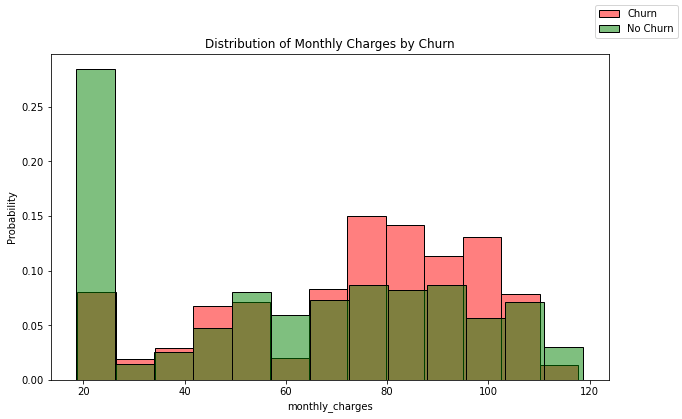

In [114]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np


fig = plt.figure(figsize=(10,6))
plt.title('Distribution of Monthly Charges by Churn')
sns.histplot(data=churn['monthly_charges'], stat='probability', color = 'red', alpha=0.5, label='Churn')
sns.histplot(data=no_churn['monthly_charges'], stat='probability', color='green', alpha=0.5, label='No Churn')
fig.legend(labels=['Churn','No Churn'])
plt.show;

### Data is not normally distributed $\therefore$  use Kruskal Wallis

The Kruskal–Wallis H test , or one-way ANOVA on ranks, is a non-parametric method for testing whether samples originate from the same distribution.

Since it is a nonparametric method, the Kruskal–Wallis test does not assume a normal distribution of the residuals, unlike the analogous one-way analysis of variance. If the researcher can make the assumptions of an identically shaped and scaled distribution for all groups, except for any difference in medians, then the null hypothesis is that the medians of all groups are equal, and the alternative hypothesis is that at least one population median of one group is different from the population median of at least one other group.

$H_0:$ Churn is independent of monthly charges

$H_1:$ Churn is dependent on monthly charges


In [234]:
import scipy

scipy.stats.kruskal(churn.monthly_charges, no_churn.monthly_charges)

KruskalResult(statistic=130.80822711455886, pvalue=2.7272064616213124e-30)

---

# Build Models

In [115]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score


### What do we want to know?

1. Are there specific segments or customers that are more likely to churn?
    - Seniors
    - Fiber Optic
    - Higher monthly bill
    - Paperless echeck
2. What features indicate a higher likelihood of churn?
3. Is there a service price above which customers churn?

To avoid excess dimensionality, will only pass features with the lowest Ps to create models.

Since we are concerned with predicting which customers will churn, we wish to minimize false negatives $\therefore$ Accuracy will be the primary evaluation metric with recall as a secondary metric.

# [Put false positive / FN/ TP / TN table from exercises here]

In [116]:
def feature_target_selector(features, target, train=telco_train, validate=telco_validate, test=telco_test):
    X_train = train[features]
    y_train = train[target]
    X_validate = validate[features]
    y_validate = validate[target]
    X_test = test[features]
    y_test = test[target]
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [117]:
telco_train.columns


Index(['customer_id', 'senior_citizen', 'tenure', 'monthly_charges',
       'total_charges', 'gender_encoded', 'partner_encoded',
       'dependents_encoded', 'phone_service_encoded',
       'paperless_billing_encoded', 'churn_encoded', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'contract_type_One year', 'contract_type_Two year',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check'],
      dtype='object')

In [118]:
features = ['senior_citizen', 'monthly_charges', 'tenure', 'paperless_billing_encoded', 'internet_service_type_Fiber optic', 'payment_type_Electronic check']
target = ['churn_encoded']
X_train, y_train, X_validate, y_validate, X_test, y_test = feature_target_selector(features, target)

## Baseline

In [119]:
telco_train.churn_encoded.mode()

0    0
dtype: int64

Most customers do not churn, so our baseline model predicts nobody will ever churn (churn=0, 100%)

In [120]:
evaluations = pd.DataFrame({"actual": y_validate.churn_encoded})
evaluations["baseline"] = 0
matrix = pd.crosstab(evaluations.actual, evaluations.baseline)
matrix

baseline,0
actual,
0,1239
1,449


In [121]:
baseline_accuracy = (evaluations.baseline == evaluations.actual).mean()

print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.40%


---

## Decision tree

In [122]:
tree = DecisionTreeClassifier(random_state = 123, max_depth = 25)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_train)
y_pred_proba = tree.predict_proba(X_train)

In [123]:
confusion_matrix(y_train, y_pred)


array([[2891,    0],
       [  30, 1016]])

In [124]:
import graphviz
from graphviz import Graph


In [125]:
def print_return_cm_details(y_pred, y_train=y_train):
    true_positive_count = confusion_matrix(y_train, y_pred)[1][1]
    print(f'True positives: {true_positive_count}')
    false_negative_count = confusion_matrix(y_train, y_pred)[1][0]
    print(f'False negatives: {false_negative_count}')
    false_positive_count = confusion_matrix(y_train, y_pred)[0][1]
    print(f'False positives: {false_positive_count}')
    true_negative_count = confusion_matrix(y_train, y_pred)[0][0]
    print(f'True negatives: {true_negative_count}')
    return true_positive_count, false_negative_count, false_positive_count, true_negative_count


In [126]:

tp, fn, fp, tn = print_return_cm_details(y_pred)

True positives: 1016
False negatives: 30
False positives: 0
True negatives: 2891


In [127]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2891
           1       1.00      0.97      0.99      1046

    accuracy                           0.99      3937
   macro avg       0.99      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [128]:
print('Decision Tree training set accuracy: {:.4f}'
     .format(tree.score(X_train, y_train)))

print('Decision Tree training set F1: {:.4f}'
     .format(f1_score(y_train, y_pred)))

recall_tree = tp/(tp+fn)

print('Decision Tree training set Recall: {:.4f}'
     .format(recall_tree))

Decision Tree training set accuracy: 0.9924
Decision Tree training set F1: 0.9855
Decision Tree training set Recall: 0.9713


---

## Random Forest

In [129]:
rf = RandomForestClassifier(random_state = 123, min_samples_leaf = 1, max_depth = 20)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
print(X_train.columns)

[0.02208226 0.48739102 0.35559728 0.02309609 0.06369742 0.04813593]
Index(['senior_citizen', 'monthly_charges', 'tenure',
       'paperless_billing_encoded', 'internet_service_type_Fiber optic',
       'payment_type_Electronic check'],
      dtype='object')


In [130]:
y_pred2 = rf.predict(X_train)
y_pred2_proba = rf.predict_proba(X_train)
print(confusion_matrix(y_train, y_pred2))

[[2887    4]
 [  24 1022]]


In [131]:
tp, fn, fp, tn = print_return_cm_details(y_pred2)


True positives: 1022
False negatives: 24
False positives: 4
True negatives: 2887


In [132]:
print(classification_report(y_train, y_pred2))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2891
           1       1.00      0.98      0.99      1046

    accuracy                           0.99      3937
   macro avg       0.99      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [133]:
print('Random Forest training set accuracy: {:.4f}'
     .format(rf.score(X_train, y_train)))

print('Random Forest training set F1: {:.4f}'
     .format(f1_score(y_train, y_pred2)))

recall_rf = tp/(tp+fn)

print('Random Forest training set Recall: {:.4f}'
     .format(recall_rf))

Random Forest training set accuracy: 0.9929
Random Forest training set F1: 0.9865
Random Forest training set Recall: 0.9771


---

## KNN

In [134]:
k = math.floor(math.sqrt(X_train.shape[0]))


In [135]:
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform') #n_neighbors is based on square root of number of observations
knn.fit(X_train, y_train)
y_pred3 = knn.predict(X_train)
y_pred3_proba = knn.predict_proba(X_train)

In [136]:
print(confusion_matrix(y_train, y_pred3))


[[2697  194]
 [ 610  436]]


In [137]:
tp, fn, fp, tn = print_return_cm_details(y_pred3)


True positives: 436
False negatives: 610
False positives: 194
True negatives: 2697


In [138]:
print(classification_report(y_train, y_pred3))


              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2891
           1       0.69      0.42      0.52      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.67      0.70      3937
weighted avg       0.78      0.80      0.78      3937



In [139]:
print('KNN Train Accuracy: {:.4f}'
     .format(knn.score(X_train, y_train)))

print('KNN Train F1: {:.4f}'
     .format(f1_score(y_train, y_pred3)))

recall_knn = tp/(tp+fn)

print('KNN Train Recall: {:.4f}'
     .format(recall_knn))

KNN Train Accuracy: 0.7958
KNN Train F1: 0.5203
KNN Train Recall: 0.4168


## Logistic Regression

In [140]:
logr = LogisticRegression(random_state=123, solver='lbfgs')
logr.fit(X_train, y_train)
print('Coefficient: \n', logr.coef_)
print('Intercept: \n', logr.intercept_)

Coefficient: 
 [[ 0.53974434  0.00978369 -0.04481712  0.49239456  0.89988463  0.53167343]]
Intercept: 
 [-1.54586777]


In [141]:
y_pred4 = logr.predict(X_train)
y_pred4_proba = logr.predict_proba(X_train)

In [142]:
confusion_matrix(y_train, y_pred4)


array([[2640,  251],
       [ 563,  483]])

In [143]:
print(classification_report(y_train, y_pred4))


              precision    recall  f1-score   support

           0       0.82      0.91      0.87      2891
           1       0.66      0.46      0.54      1046

    accuracy                           0.79      3937
   macro avg       0.74      0.69      0.70      3937
weighted avg       0.78      0.79      0.78      3937



In [144]:
print('Logistic Regression training Accuracy: {:.4f}'
     .format(logr.score(X_train, y_train)))

print('Logistic Regression Training F1: {:.4f}'
     .format(f1_score(y_train, y_pred4)))

recall_logr = tp/(tp+fn)

print('Logistic Regression training Recall: {:.4f}'
     .format(recall_logr))

Logistic Regression training Accuracy: 0.7932
Logistic Regression Training F1: 0.5427
Logistic Regression training Recall: 0.4168


---

## Validate

In [145]:
print("Model 1: Decision Tree")

print('Accuracy: {:.4f}'.format(tree.score(X_validate, y_validate)))

y_pred_val = tree.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_val))

print(classification_report(y_validate, y_pred_val))

Model 1: Decision Tree
Accuracy: 0.7216
[[1003  236]
 [ 234  215]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1239
           1       0.48      0.48      0.48       449

    accuracy                           0.72      1688
   macro avg       0.64      0.64      0.64      1688
weighted avg       0.72      0.72      0.72      1688



In [146]:
print("Model 2: Random Forest")

print('Accuracy: {:.4f}'.format(rf.score(X_validate, y_validate)))

y_pred_rf = rf.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_rf))

print(classification_report(y_validate, y_pred_rf))

Model 2: Random Forest
Accuracy: 0.7713
[[1079  160]
 [ 226  223]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1239
           1       0.58      0.50      0.54       449

    accuracy                           0.77      1688
   macro avg       0.70      0.68      0.69      1688
weighted avg       0.76      0.77      0.77      1688



In [147]:
print("Model 3: K-Nearest Neighbors")

print('Accuracy: {:.4f}'.format(knn.score(X_validate, y_validate)))

y_pred_knn = knn.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_knn))

print(classification_report(y_validate, y_pred_knn))

Model 3: K-Nearest Neighbors
Accuracy: 0.7909
[[1142   97]
 [ 256  193]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1239
           1       0.67      0.43      0.52       449

    accuracy                           0.79      1688
   macro avg       0.74      0.68      0.69      1688
weighted avg       0.78      0.79      0.77      1688



In [148]:
print("Model 4: Logistic Regression")

print('Accuracy: {:.4f}'.format(logr.score(X_validate, y_validate)))

y_pred_lr = logr.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_lr))

print(classification_report(y_validate, y_pred_lr))

Model 4: Logistic Regression
Accuracy: 0.7927
[[1117  122]
 [ 228  221]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1239
           1       0.64      0.49      0.56       449

    accuracy                           0.79      1688
   macro avg       0.74      0.70      0.71      1688
weighted avg       0.78      0.79      0.78      1688



---

## Test

## [DO NOT RUN YET]
## [Use GridSearchCV and RandomSearchCV on existing models first]

In [149]:
print("Test Performance: [Logistic Regression")

print('Accuracy: {:.4f}'.format(logr.score(X_test, y_test)))

y_pred_test = logr.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

Test Performance: [Logistic Regression
Accuracy: 0.8003
[[940  93]
 [188 186]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.67      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



---

## Prediction CSV

In [213]:
telco_df

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,prediction
0,0016-QLJIS,0,65,90.45,5957.90,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0
1,0017-DINOC,0,54,45.20,2460.55,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0
2,0019-GFNTW,0,56,45.05,2560.10,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0
3,0056-EPFBG,0,20,39.40,825.40,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0
4,0078-XZMHT,0,72,85.15,6316.20,0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9962-BFPDU,0,1,20.05,20.05,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7039,9967-ATRFS,0,19,19.90,367.55,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7040,9970-QBCDA,0,6,19.70,129.55,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
7041,9975-SKRNR,0,1,18.90,18.90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [214]:
telco_df_trim = telco_df[['senior_citizen', 'monthly_charges', 'tenure', 'paperless_billing_encoded', 'internet_service_type_Fiber optic', 'payment_type_Electronic check']]

In [215]:
telco_df_trim

,senior_citizen,monthly_charges,tenure,paperless_billing_encoded,internet_service_type_Fiber optic,payment_type_Electronic check
0,0,90.45,65,1,0,0
1,0,45.20,54,0,0,0
2,0,45.05,56,0,0,0
3,0,39.40,20,1,0,0
4,0,85.15,72,1,0,0
...,...,...,...,...,...,...
7038,0,20.05,1,0,0,0
7039,0,19.90,19,0,0,0
7040,0,19.70,6,0,0,0
7041,0,18.90,1,0,0,0


In [216]:


telco_df_trim['prediction'] = logr.predict(telco_df_trim)


In [217]:
telco_df

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,prediction
0,0016-QLJIS,0,65,90.45,5957.90,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0
1,0017-DINOC,0,54,45.20,2460.55,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0
2,0019-GFNTW,0,56,45.05,2560.10,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0
3,0056-EPFBG,0,20,39.40,825.40,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0
4,0078-XZMHT,0,72,85.15,6316.20,0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9962-BFPDU,0,1,20.05,20.05,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7039,9967-ATRFS,0,19,19.90,367.55,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7040,9970-QBCDA,0,6,19.70,129.55,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
7041,9975-SKRNR,0,1,18.90,18.90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [218]:
predictions = telco_df[['customer_id', 'prediction']]
predictions.head()

,customer_id,prediction
0,0016-QLJIS,0
1,0017-DINOC,0
2,0019-GFNTW,0
3,0056-EPFBG,0
4,0078-XZMHT,0


In [168]:
df =telco_df_trim[['senior_citizen', 'monthly_charges', 'tenure', 'paperless_billing_encoded', 'internet_service_type_Fiber optic', 'payment_type_Electronic check']]

In [169]:
df

,senior_citizen,monthly_charges,tenure,paperless_billing_encoded,internet_service_type_Fiber optic,payment_type_Electronic check
0,0,90.45,65,1,0,0
1,0,45.20,54,0,0,0
2,0,45.05,56,0,0,0
3,0,39.40,20,1,0,0
4,0,85.15,72,1,0,0
...,...,...,...,...,...,...
7038,0,20.05,1,0,0,0
7039,0,19.90,19,0,0,0
7040,0,19.70,6,0,0,0
7041,0,18.90,1,0,0,0


In [212]:
predictions.to_csv('predictions.csv')


In [219]:
# Get probability for predictions

prob =logr.predict_proba(df)


In [178]:
prob

array([[0.9561295 , 0.0438705 ],
       [0.97135657, 0.02864343],
       [0.97378532, 0.02621468],
       ...,
       [0.83507515, 0.16492485],
       [0.80309841, 0.19690159],
       [0.82056322, 0.17943678]])

In [204]:
len(prob)

7032

In [205]:
prob2=prob[0]

In [226]:
prob

array([[0.9561295 , 0.0438705 ],
       [0.97135657, 0.02864343],
       [0.97378532, 0.02621468],
       ...,
       [0.83507515, 0.16492485],
       [0.80309841, 0.19690159],
       [0.82056322, 0.17943678]])

In [207]:
telco_df_trim.shape

(7032, 7)

In [221]:
prob2

array([0.9561295, 0.0438705])

In [209]:
len(prob2)

2

In [225]:
prob2

array([0.9561295, 0.0438705])

In [228]:
telco_df['probability']=prob.max(axis=1)

In [229]:
telco_df

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,prediction,probability
0,0016-QLJIS,0,65,90.45,5957.90,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0.956130
1,0017-DINOC,0,54,45.20,2460.55,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0.971357
2,0019-GFNTW,0,56,45.05,2560.10,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0.973785
3,0056-EPFBG,0,20,39.40,825.40,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0.826975
4,0078-XZMHT,0,72,85.15,6316.20,0,1,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0.969148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9962-BFPDU,0,1,20.05,20.05,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.801313
7039,9967-ATRFS,0,19,19.90,367.55,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.900491
7040,9970-QBCDA,0,6,19.70,129.55,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0.835075
7041,9975-SKRNR,0,1,18.90,18.90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.803098


In [230]:
predictions = telco_df[['customer_id', 'prediction', 'probability']]


In [231]:
predictions

,customer_id,prediction,probability
0,0016-QLJIS,0,0.956130
1,0017-DINOC,0,0.971357
2,0019-GFNTW,0,0.973785
3,0056-EPFBG,0,0.826975
4,0078-XZMHT,0,0.969148
...,...,...,...
7038,9962-BFPDU,0,0.801313
7039,9967-ATRFS,0,0.900491
7040,9970-QBCDA,0,0.835075
7041,9975-SKRNR,0,0.803098


In [232]:
predictions.to_csv('predictions.csv')
